#### Hartree-Fock in Pytorch

In [1]:
from NSMFermions.hamiltonian_utils import FermiHubbardHamiltonian
from NSMFermions.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState
import numpy as np

from typing import Dict
import scipy
from NSMFermions.qml_models import AdaptVQEFermiHubbard
from NSMFermions.qml_utils.train import Fit
from NSMFermions.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from src.hartree_fock_library import HFEnergyFunctional,HFEnergyFunctionalNuclear, transform_integrals_full_unitary,transform_integrals_block_optimized
import torch
import torch.nn as nn
import torch.optim as optim

file_name='data/cki'


SPS=SingleParticleState(file_name=file_name)

/home/ecosta/miniconda3/envs/annealing-nsm-env/lib/python3.10/site-packages/tqdm_joblib/__init__.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:01<00:00, 10.88it/s]


In [65]:
nparticles_a=4
nparticles_b=4

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{8}$Be'

In [66]:

# Compute the J^2 value
#J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])

#Quadrupole Operator


# compute the NSM Hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])

NSMHamiltonian.get_twobody_interaction_optimized(twobody_dict=twobody_matrix)

NSMHamiltonian.get_hamiltonian()

egs,psigs=NSMHamiltonian.get_spectrum(n_states=10)

print(egs)

print('total_m=',SPS.compute_m_exp_value(psi=psigs,basis=NSMHamiltonian.basis))
#print('j_value=',J2Class.j_value(psi0))
print('dimension=',NSMHamiltonian.hamiltonian.shape[0])

size= 12 6
Building two-body operator with 1424 terms...


  0%|          | 0/1424 [00:00<?, ?it/s]

100%|██████████| 1424/1424 [00:00<00:00, 16067.62it/s]

✅ Two-body operator built: shape=(51, 51), nnz=1155
[-71.09941964 -66.6159574  -58.63893773 -57.59816396 -57.34683639
 -55.6619558  -54.33936695 -53.9762607  -52.65049103 -52.32862193]
total_m= [-1.60461922e-17 -2.77555756e-17  5.83300769e-17  1.09287579e-16
 -1.45012041e-17 -5.42101086e-20  3.46944695e-18  2.77691281e-17
  2.16840434e-19  3.27429056e-17]
dimension= 51


Hartree-Fock method

In [67]:
#model=HFEnergyFunctional(h_vec=torch.tensor(SPS.energies),V_dict=twobody_matrix,num_particles=nparticles_a+nparticles_b)
model=HFEnergyFunctionalNuclear(h_vec=torch.tensor(SPS.energies,dtype=torch.double),V_dict=twobody_matrix,num_neutrons=nparticles_a,num_protons=nparticles_b,neutron_indices=0,proton_indices=size_a)
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_steps = 600
for step in range(num_steps):
    optimizer.zero_grad()
    energy = model()  # calls forward()
    energy.backward()
    optimizer.step()

    if step % 20 == 0 or step == num_steps - 1:
        print(f"Step {step:4d} | Energy = {energy.item():.6f}")

Step    0 | Energy = -42.364094
Step   20 | Energy = -50.054890
Step   40 | Energy = -55.450392
Step   60 | Energy = -60.605312
Step   80 | Energy = -63.065517
Step  100 | Energy = -64.395924
Step  120 | Energy = -65.099553
Step  140 | Energy = -65.483010
Step  160 | Energy = -65.684422
Step  180 | Energy = -65.780249
Step  200 | Energy = -65.820457
Step  220 | Energy = -65.835106
Step  240 | Energy = -65.839703
Step  260 | Energy = -65.840939
Step  280 | Energy = -65.841223
Step  300 | Energy = -65.841277
Step  320 | Energy = -65.841286
Step  340 | Energy = -65.841287
Step  360 | Energy = -65.841287
Step  380 | Energy = -65.841287
Step  400 | Energy = -65.841287
Step  420 | Energy = -65.841287
Step  440 | Energy = -65.841287
Step  460 | Energy = -65.841287
Step  480 | Energy = -65.841287
Step  500 | Energy = -65.841287
Step  520 | Energy = -65.841287
Step  540 | Energy = -65.841287
Step  560 | Energy = -65.841287
Step  580 | Energy = -65.841287
Step  599 | Energy = -65.841287


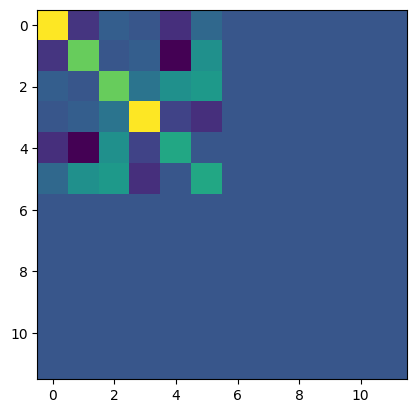

In [68]:


plt.imshow(model.rho_n.detach().numpy())
plt.show()

torch.Size([12, 12])


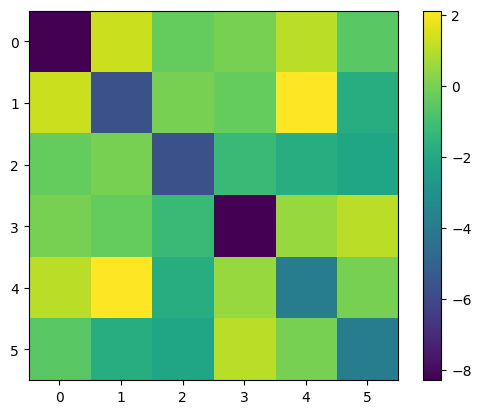

tensor([[ 1.6300e+00,  3.9218e-17, -5.9254e-12,  1.8625e-12, -1.0494e-12,
         -7.5385e-12,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 3.5379e-17,  1.6300e+00,  1.4766e-11, -4.4040e-12,  2.3286e-12,
          1.8738e-11,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-5.9253e-12,  1.4766e-11,  1.8858e+00, -2.0279e-12, -5.1867e-02,
          3.0918e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.8625e-12, -4.4040e-12, -2.0279e-12,  1.8858e+00, -3.0918e-01,
         -5.1867e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-1.0494e-12,  2.3286e-12, -5.1867e-02, -3.0918e-01,  2.0142e+00,
         -4.1314e-12,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-7.5385e-12,  1.8737e-11,  3.0918e-01, -5.1867e-02, -4.1315e-12,
      

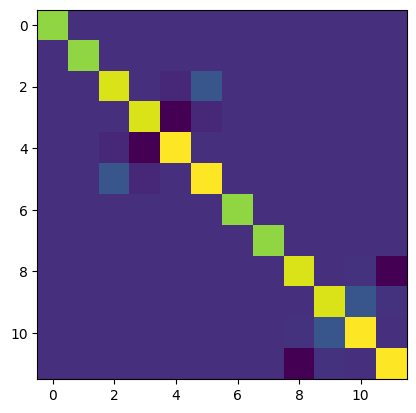

In [69]:
v_ext=torch.diag(model.h)


print(model.rho_n.shape)
fock_operator_n,fock_operator_p=model.build_fock_matrices_factorized()
plt.imshow(fock_operator_n.detach().numpy())
plt.colorbar()
plt.show()
_, unitary_n = torch.linalg.eigh(fock_operator_n)   # columns of U_can are eigenvectors
_, unitary_p = torch.linalg.eigh(fock_operator_p)   # columns of U_can are eigenvectors


h_p, V_p,_ = transform_integrals_block_optimized(unitary_n.T,unitary_p.T,v_ext,model.V_tensor)
print(h_p)
plt.imshow(h_p.detach().numpy())
plt.show()

U=torch.zeros((size_a+size_b,size_a+size_b),dtype=torch.double)
U[:size_a,:size_a]=unitary_n
U[size_a:,size_a:]=unitary_p
h_p,V_p=transform_integrals_full_unitary(U.T,model.h,model.V_tensor)


In [70]:
new_energies=np.diag(h_p.detach().numpy())
print(new_energies)

new_twobody_matrix={}
for a in range(size_a+size_b):
    for b in range(size_a+size_b):
        for c in range(size_a+size_b):
            for d in range(size_a+size_b):
                if np.abs(V_p[a,b,c,d].detach().numpy())>=10**-7:
                    new_twobody_matrix[(a,b,c,d)]=V_p[a,b,c,d].detach().numpy()

[1.63       1.63       1.88584095 1.88584095 2.01415905 2.01415905
 1.63       1.63       1.88584095 1.88584095 2.01415905 2.01415905]


In [71]:
print((new_twobody_matrix))
print(nparticles_b,nparticles_a)

{(0, 1, 0, 1): array(-1.6921), (0, 1, 1, 0): array(1.6921), (0, 1, 2, 3): array(3.21108522), (0, 1, 2, 4): array(-1.53244045), (0, 1, 2, 5): array(-0.2570769), (0, 1, 3, 2): array(-3.21108522), (0, 1, 3, 4): array(0.2570769), (0, 1, 3, 5): array(-1.53244045), (0, 1, 4, 2): array(1.53244045), (0, 1, 4, 3): array(-0.2570769), (0, 1, 4, 5): array(1.59587347), (0, 1, 5, 2): array(0.2570769), (0, 1, 5, 3): array(1.53244045), (0, 1, 5, 4): array(-1.59587347), (0, 2, 0, 2): array(-0.94915942), (0, 2, 0, 3): array(-1.91608307), (0, 2, 0, 4): array(0.67738867), (0, 2, 0, 5): array(0.18081544), (0, 2, 1, 2): array(-6.08048101e-07), (0, 2, 1, 3): array(8.5519652e-06), (0, 2, 1, 4): array(-3.03565033e-06), (0, 2, 1, 5): array(-7.33825769e-07), (0, 2, 2, 0): array(0.94915942), (0, 2, 2, 1): array(6.08048101e-07), (0, 2, 2, 4): array(-0.38753615), (0, 2, 2, 5): array(0.25595394), (0, 2, 3, 0): array(1.91608307), (0, 2, 3, 1): array(-8.5519652e-06), (0, 2, 3, 4): array(-0.41606725), (0, 2, 3, 5): arr

In [87]:
NSMFockHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b)
# one body term:
one_body_term=0.
for a in range(size_a+size_b):
    for b in range(size_a+size_b):
        one_body_term+=h_p[a,b].detach().numpy()*NSMFockHamiltonian.adag_a_matrix_optimized(a,b)


NSMFockHamiltonian.get_twobody_interaction_optimized(new_twobody_matrix)
NSMFockHamiltonian.get_hamiltonian()
NSMFockHamiltonian.hamiltonian+=one_body_term
egs,psigshf=NSMFockHamiltonian.get_spectrum(10)

print(egs)
print(psigshf.shape)

Building two-body operator with 6048 terms...


100%|██████████| 6048/6048 [00:00<00:00, 12151.86it/s]


✅ Two-body operator built: shape=(225, 225), nnz=19389
[-71.09941964 -66.61595741 -66.61595741 -66.6159574  -66.6159574
 -66.6159574  -58.63893773 -58.63893773 -58.63893772 -57.59816396]
(225, 10)


In [93]:
from NSMFermions.utils_quasiparticle_approximation import QuasiParticlesConverterOnlynnpp

QPC=QuasiParticlesConverterOnlynnpp()
QPC.initialize_shell(state_encoding=SPS.state_encoding)
QPC.get_the_basis_matrix_transformation(NSMHamiltonian.basis)


QPCHF=QuasiParticlesConverterOnlynnpp()
QPCHF.initialize_shell(state_encoding=SPS.state_encoding)


new_couples=[]
for i in range(0,size_a,2):

    new_couples.append([i+6,i+7])
    new_couples.append([i,i+1])
    new_couples.append([i,i+6])
    new_couples.append([i+1,i+7])
    
    


    
QPCHF.couples=new_couples


QPCHF.get_the_basis_matrix_transformation(NSMFockHamiltonian.basis)

print(QPCHF.quasiparticle_basis.shape)


(21, 12)


In [94]:
print(QPC.quasiparticle_basis.shape)
hamiltonian_Q=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
egsQ,psi_Q=eigsh(hamiltonian_Q,k=8,which='SA')

hamiltonian_QHF=QPCHF.particles2quasiparticles @ NSMFockHamiltonian.hamiltonian @ QPCHF.particles2quasiparticles.T
egsQnp,psi_Qnp=eigsh(hamiltonian_QHF,k=5,which='SA')

print(egsQnp,egsQ)






print('\n')

#print(psigs[:,0].dot(psi_Q2particle.conj())*np.conjugate(psigs[:,0].dot(psi_Q2particle.conj())))
fs=[]
for i in range(egsQnp.shape[0]):
    psi_Qnp2particle=QPCHF.particles2quasiparticles.T @ psi_Qnp[:,i]
    psi_Qnp2particle/=np.linalg.norm(psi_Qnp2particle)
    print(psigshf[:,0].dot(psi_Qnp2particle.conj())*np.conjugate(psigshf[:,0].dot(psi_Qnp2particle.conj())))#,j_values[i])
    fs.append(psigshf[:,0].dot(psi_Qnp2particle.conj())*np.conjugate(psigshf[:,0].dot(psi_Qnp2particle.conj())))
print('\n')
print(np.sum(fs),'\n')
fs=[]
for i in range(egsQ.shape[0]):
    psi_Q2particle=QPC.particles2quasiparticles.T @ psi_Q[:,i]
    psi_Q2particle/=np.linalg.norm(psi_Q2particle)
    
    print(psigs[:,0].dot(psi_Q2particle.conj())*np.conjugate(psigs[:,0].dot(psi_Q2particle.conj())))#,j_values[0])
    fs.append(psigs[:,0].dot(psi_Q2particle.conj())*np.conjugate(psigs[:,0].dot(psi_Q2particle.conj())))
print('\n')
print(np.sum(fs))


(9, 6)
[-66.99068263 -58.60819211 -51.8092648  -51.521719   -50.26369602] [-65.11417103 -50.58745117 -50.40839101 -48.92109253 -48.6094
 -39.51121447 -39.23056899 -34.70729747]


0.40406121144135043
0.23859588446457802
0.009645043106189044
4.5087907144182817e-23
7.288512049799602e-24


0.6523021390121175 

0.6719694286817582
0.045191191082750694
7.920933860396713e-28
4.254379247151404e-31
1.0546392375464504e-30
0.00010111132326494646
2.2263750157116446e-31
1.560003254953661e-32


0.7172617310877739
